In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import eli5

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id')

# # приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [3]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

Alice sessions by the hours

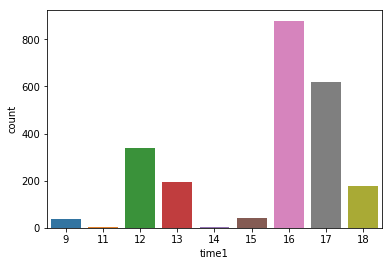

In [4]:
fig , (ax1, ax2) = plt.subplots(1, 2, figsize = ( 15 , 6 )) 
fig.suptitle('Distribution of hours of sessions per day', fontsize=16)
sns.countplot(train_df[train_df['target'] == 1]['time1'].apply(lambda t: t.hour));

Text(0.5, 1.0, 'Test distribution')

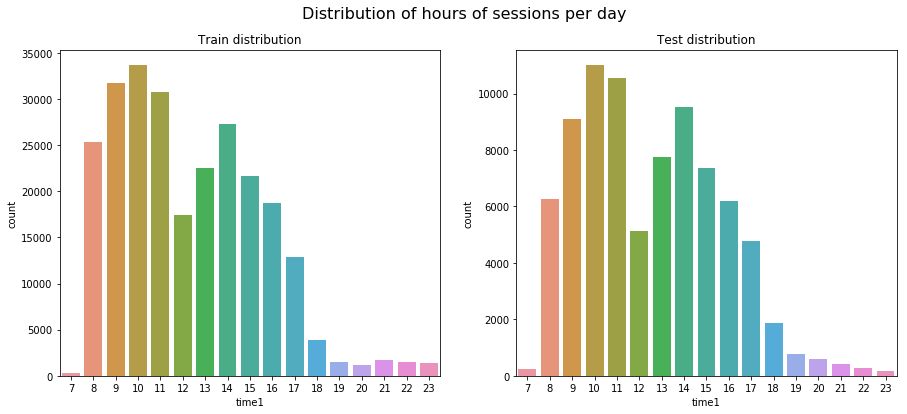

In [7]:
fig , (ax1, ax2) = plt.subplots(1, 2, figsize = ( 15 , 6 )) 
fig.suptitle('Distribution of hours of sessions per day', fontsize=16) 

sns.countplot(train_df['time1'].apply(lambda t: t.hour),ax=ax1) 
ax1.set_title("Train distribution") 

sns.countplot(test_df[train_df['target'] == 0]['time1'].apply(lambda t: t.hour),ax=ax2) 
ax2.set_title("Test distribution")

In [15]:
def fe(X, y):
    # intraday features
    hour = X['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 9) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 8)).astype('int')

    # season features
    month = X['time1'].apply(lambda ts: ts.month)
    summer = ((month >= 6) & (month <= 8)).astype('int')

    # day of the week features
    weekday = X['time1'].apply(lambda ts: ts.weekday()).astype('int')

    # year features
    year = X['time1'].apply(lambda ts: ts.year).astype('int')
    
    work_hours = ((hour >= 9) & (hour <= 18)).astype('int') & (weekday <= 4)

    feature = ['hour', 'morning', 'day', 'evening', 'night', 'summer', 'weekday', 'year', 'work_hours', 'target']
    X = np.c_[hour.values, morning.values, day.values, evening.values, night.values,
              summer.values, weekday.values, year.values, work_hours.values, y]
    
    res = pd.DataFrame(X, columns=feature)
    return res

In [16]:
feature = fe(train_df, train_df['target'])
feature.head()

,hour,morning,day,evening,night,summer,weekday,year,work_hours,target
0,10,1,0,0,0,0,3,2014,1,0
1,11,1,0,0,0,0,5,2014,0,0
2,16,0,1,0,0,0,0,2013,1,0
3,10,1,0,0,0,0,4,2014,1,0
4,10,1,0,0,0,0,4,2014,1,0


In [12]:
feature[feature['target'] == 1]['work_hours'].value_counts()

1    2255
0      42
Name: work_hours, dtype: int64

Text(0.5, 1.0, 'Others')

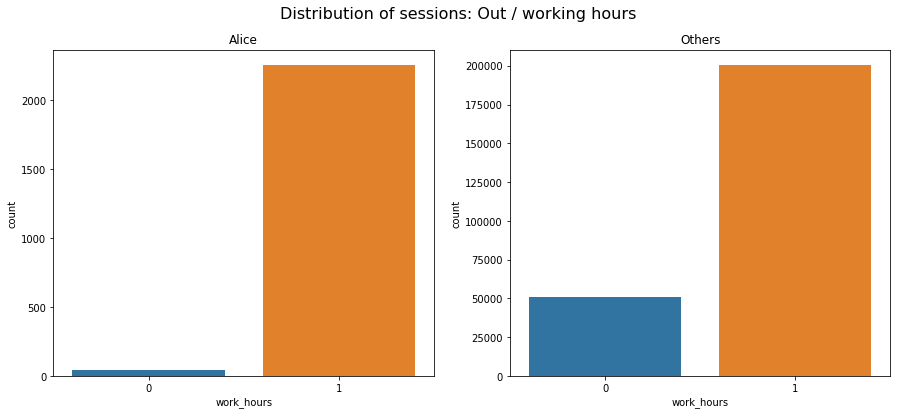

In [14]:
fig , (ax1, ax2) = plt.subplots(1, 2, figsize = ( 15 , 6 )) 
fig.suptitle('Distribution of sessions: Out / working hours', fontsize=16) 

sns.countplot(feature[feature['target'] == 1]['work_hours'], ax=ax1)
ax1.set_title("Alice")

sns.countplot(feature[feature['target'] == 0]['work_hours'], ax=ax2)
ax2.set_title("Others")

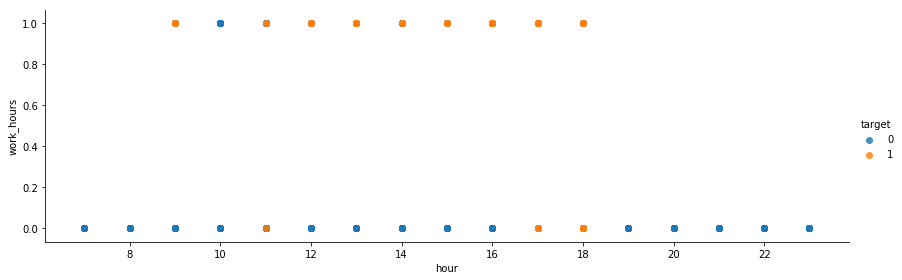

In [30]:
sns.lmplot('hour', 'work_hours', data=feature, hue='target', fit_reg=False, height=4, aspect=3)

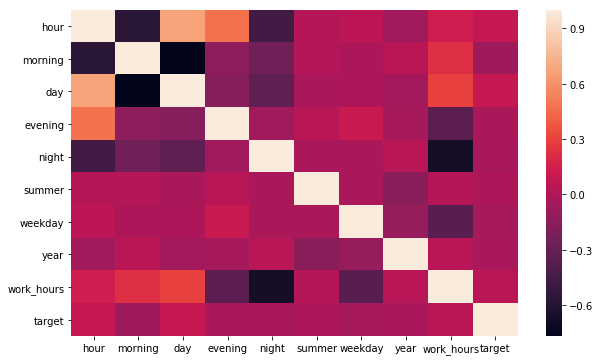

In [17]:
plt.figure(figsize = ( 10 , 6 )) 
sns.heatmap(feature.corr())

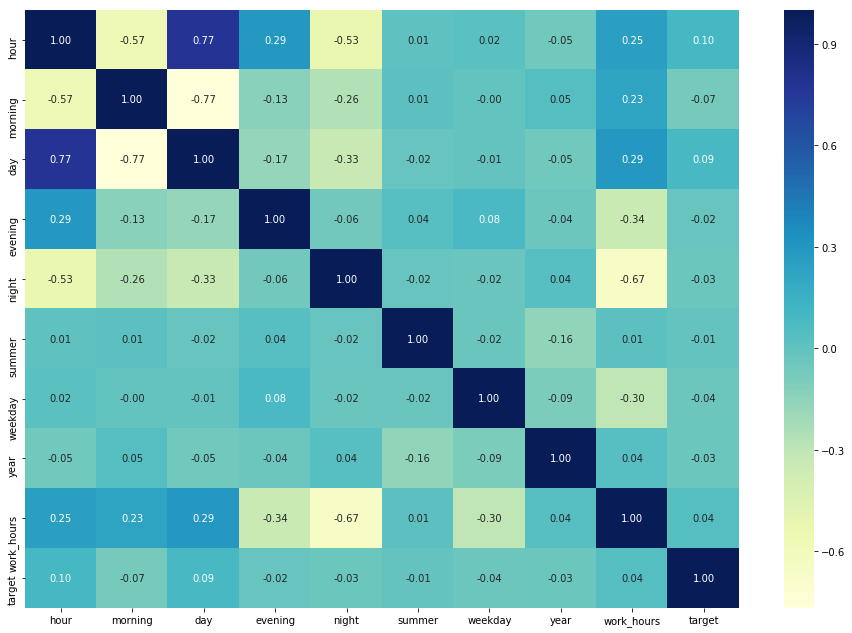

In [18]:
corr = feature.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");